In [1]:
import sys
import os
# Dynamically get the path of the current directory
current_dir = os.getcwd()

# Assuming the package is one level up
local_package_dir = os.path.abspath(os.path.join(current_dir, '..'))

# Add this path to sys.path
sys.path.insert(0, local_package_dir)

# Now you can import your local package
from util import validate
import pandas as pd

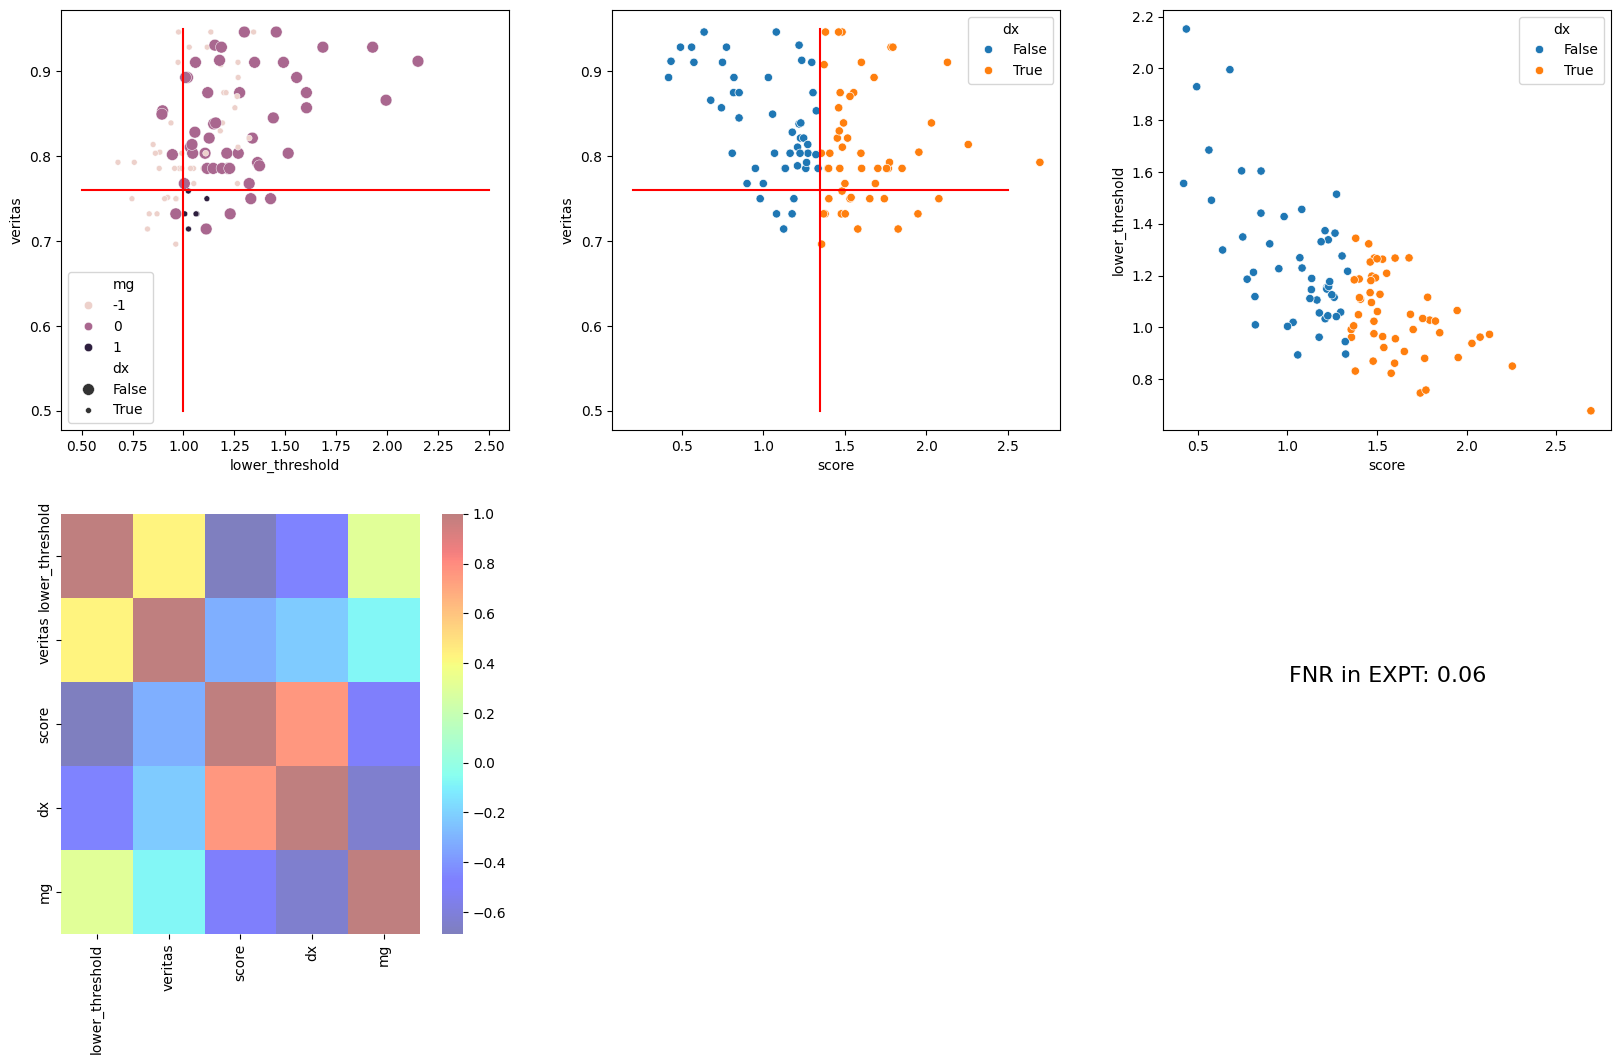

In [3]:
resf=pd.read_csv('../../data/res_exp2_model2_screened.csv',index_col=0).T
resf.columns=['lower_threshold','veritas','score']
d1,wf1=validate(resf,C0=1,C1=0.76,C2=1.35,DX=False,score=True,
         outfile='exptvalid.png',
         validation_type='fnrexpt')

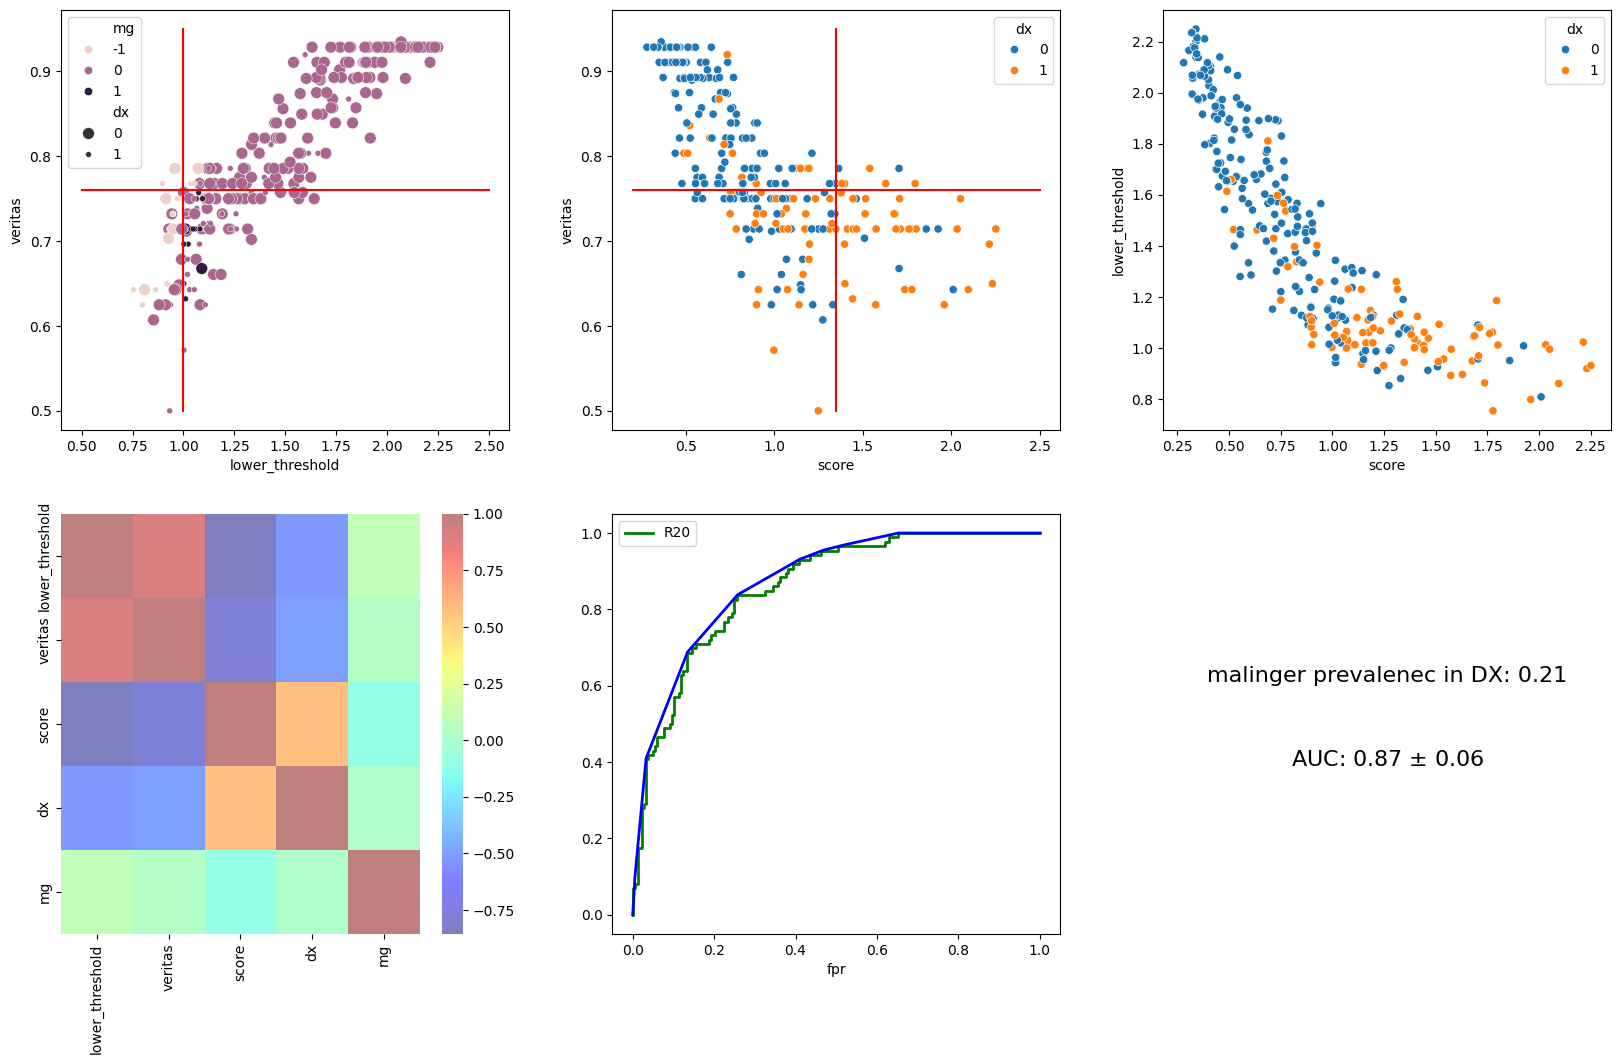

In [4]:
resf=pd.read_csv('../../data/res_R20_model2.csv',index_col=0).T
resf.columns=['lower_threshold','veritas','score']
resf['dx'] = [int(x[-1]) for x in resf.index.values]
d2,wf2,zt=validate(resf,C0=1,C1=0.76,C2=1.35,DX=True,score=True,verbose=False,
         outfile='ptsdvalid.png',
         validation_type='withdx')

In [5]:
from truthnet import load_veritas_model

In [6]:
M=load_veritas_model('../../veritas_models/veritas_002.pkl.gz')

In [7]:
M

{'version': '0.0.1',
 'model': qnet.Qnet,
 'model_neg': qnet.Qnet,
 'problem': '',
 'calibration_lower': array([1.20398725, 1.20398725, 1.20398725, ..., 1.29696621, 1.29880653,
        1.29880653]),
 'calibration_veritas': array([0.65791448, 0.65791448, 0.65791448, ..., 0.69963702, 0.68822158,
        0.68822158]),
 'dist_lower': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7f221da95b50>,
 'LOWER_THRESHOLD': 1.1457407246215392,
 'dist_veritas': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7f221da9bbe0>,
 'VERITAS_THRESHOLD': 0.6971038897415065,
 'upper_scoretoprobability': <bound method processRoc.scoretoprobability of <zedstat.zedstat.processRoc object at 0x7f221daa0190>>,
 'UPPER_THRESHOLD': 1.2683587177075477,
 'AUC': (0.844551724137931, 0.8521131405190563, 0.8369903077568057)}

In [8]:
lf=M['calibration_lower']
xmin,xmax=1,1.4
ld=M['dist_lower']

In [9]:
vf=M['calibration_veritas']
vd=M['dist_veritas']
xmind,xmaxd=vf.min(),vf.max()

In [10]:
wf2.columns=[r'$\kappa$',r'$\nu$',r'$\mu$','DX',r'$\chi$']
wf2

,$\kappa$,$\nu$,$\mu$,DX,$\chi$
CAT10050,1.766693,0.901883,0.680022,0,0
CAT10010,0.928472,0.714286,1.248364,0,0
CAT10020,1.117376,0.785714,1.025116,0,0
CAT10030,1.308874,0.767857,1.061628,0,0
CAT10040,1.775565,0.892857,0.684865,0,0
...,...,...,...,...,...
CAT12990,1.286232,0.767857,0.606269,0,0
CAT13011,1.133075,0.720779,1.325811,1,0
CAT13020,1.523528,0.793067,0.720745,0,0
CAT13040,1.895962,0.910714,0.444272,0,0


In [61]:
resf1=pd.read_csv('../../data/res_exp2_model2_screened.csv',index_col=0).T
resf1.columns=['lower_threshold','veritas','score']

resf=pd.read_csv('../../data/res_R20_model2.csv',index_col=0).T
resf.columns=['lower_threshold','veritas','score']
resf['dx'] = [int(x[-1]) for x in resf.index.values]

import numpy as np
from tqdm import tqdm
R={}
for c0 in tqdm(np.arange(.6,1.2,.05)):
    for c2 in tqdm(np.arange(1,1.7,.05)):
        b,_,_=validate(resf,C0=c0,C1=0.76,C2=c2,DX=True,
                   score=True,plots=False,verbose=False,
                   validation_type='withdx')
    
        a,_=validate(resf1,C0=c0,C1=0.76,C2=1.35,DX=False,score=True,plots=False,
                   validation_type='fnrexpt')

        R[(c0,c2)]=(1-a['fnr'],1-b['mratio'],1 - 0.5*(a['fnr'] + b['mratio']+a['fnr']*b['mratio'] ))

rf=pd.DataFrame(R).T
rf.columns=['sensitivity','maxspecificity','minauc']
print(rf)

rf.index.name='thresholds'
rff=rf[['sensitivity','maxspecificity']].reset_index()
rff=rff.rename(columns={'sensitivity':'tpr'})
rff['fpr']=1-rff.maxspecificity
rff=rff.drop('maxspecificity',axis=1)
print(rff)

from zedstat import zedstat
ztm=zedstat.processRoc(df=rff,
                      order=3, 
                      total_samples=304+210,
                      positive_samples=210,
                      alpha=0.01,
                      prevalence=0.31)
ztm.smooth(STEP=0.1)
ztm.allmeasures(interpolate=True)
ztm.usample(precision=2)
ztm.auc()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [08:04<00:00, 40.39s/it]


           sensitivity  maxspecificity    minauc
0.60 1.00         0.85        0.883721  0.858140
     1.05         0.85        0.883721  0.858140
     1.10         0.85        0.883721  0.858140
     1.15         0.85        0.918605  0.878198
     1.20         0.85        0.941860  0.891570
     1.25         0.85        0.941860  0.891570
     1.30         0.85        0.941860  0.891570
     1.35         0.85        0.941860  0.891570
     1.40         0.85        0.965116  0.904942
     1.45         0.85        0.965116  0.904942
     1.50         0.85        0.965116  0.904942
     1.55         0.85        0.976744  0.911628
     1.60         0.85        0.976744  0.911628
     1.65         0.85        0.988372  0.918314
0.65 1.00         0.85        0.883721  0.858140
     1.05         0.85        0.883721  0.858140
     1.10         0.85        0.883721  0.858140
     1.15         0.85        0.918605  0.878198
     1.20         0.85        0.941860  0.891570
     1.25         0.

(0.9389, 0.9518779880627515, 0.9259220119372484)

In [62]:
rf.reset_index().to_csv('minaucres.csv',index=None)

In [63]:
rf.index.name=('C0','C2')
rf_=rf.reset_index()
rf_.columns=['C0', 'C2', 'sensitivity', 'maxspecificity', 'minauc']
rf_

,C0,C2,sensitivity,maxspecificity,minauc
0,0.60,1.00,0.85,0.883721,0.858140
1,0.60,1.05,0.85,0.883721,0.858140
2,0.60,1.10,0.85,0.883721,0.858140
3,0.60,1.15,0.85,0.918605,0.878198
4,0.60,1.20,0.85,0.941860,0.891570
5,0.60,1.25,0.85,0.941860,0.891570
6,0.60,1.30,0.85,0.941860,0.891570
7,0.60,1.35,0.85,0.941860,0.891570
8,0.60,1.40,0.85,0.965116,0.904942
9,0.60,1.45,0.85,0.965116,0.904942


In [64]:
rf_[(rf_.C0.between(.95,1.1)) & (rf_.C2.between(1.3,1.4))]

,C0,C2,sensitivity,maxspecificity,minauc
104,0.95,1.30,0.91,0.825581,0.859942
105,0.95,1.35,0.91,0.837209,0.866279
118,1.00,1.30,0.94,0.779070,0.852907
119,1.00,1.35,0.94,0.790698,0.859070
132,1.05,1.30,0.97,0.662791,0.811337
133,1.05,1.35,0.97,0.674419,0.817326


In [65]:
rf_[(rf_.sensitivity>.9) & (rf_.maxspecificity>.9)& (rf_.C2<1.7)]

,C0,C2,sensitivity,maxspecificity,minauc
111,0.95,1.65,0.91,0.906977,0.904302


In [66]:
rff=rf_[['sensitivity','maxspecificity']].reset_index()
rff=rff.rename(columns={'sensitivity':'tpr'})
rff['fpr']=1-rff.maxspecificity
rff=rff.drop('maxspecificity',axis=1)
from zedstat import zedstat
ztmx=zedstat.processRoc(df=rff,
                      order=3, 
                      total_samples=304+210,
                      positive_samples=210,
                      alpha=0.01,
                      prevalence=0.31)
ztmx.smooth(STEP=0.1)
ztmx.allmeasures(interpolate=True)
ztmx.usample(precision=2)
ztmx.auc()

(0.9389, 0.9518779880627515, 0.9259220119372484)

In [67]:
ZX=ztmx.get().dropna()
ZX[ZX.ppv>.8]

,tpr,ppv,acc,npv,LR+,LR-
fpr,,,,,,
0.00,0.000,0.863836,0.690000,0.690000,17.977854,1.000000
0.01,0.091,0.858364,0.711791,0.716732,17.158319,0.909923
0.02,0.182,0.852893,0.733583,0.743464,16.338783,0.819846
0.03,0.273,0.847421,0.755374,0.770196,15.519248,0.729769
0.04,0.364,0.841949,0.777166,0.796928,14.699713,0.639692
0.05,0.455,0.836478,0.798957,0.823660,13.880177,0.549615
0.06,0.546,0.831006,0.820748,0.850392,13.060642,0.459538
0.07,0.637,0.825534,0.842540,0.877125,12.241106,0.369462
0.08,0.728,0.820063,0.864331,0.903857,11.421571,0.279385


In [60]:
pd.set_option('display.max_rows', None)

ZX

,tpr,ppv,acc,npv,LR+,LR-
fpr,,,,,,
0.10,1.0,0.822767,0.928937,1.0,10.642857,0.0
0.11,1.0,0.817070,0.922060,1.0,10.535714,0.0
0.12,1.0,0.811373,0.915183,1.0,10.428571,0.0
0.13,1.0,0.805675,0.908306,1.0,10.321429,0.0
0.14,1.0,0.799978,0.901429,1.0,10.214286,0.0
0.15,1.0,0.794280,0.894551,1.0,10.107143,0.0
0.16,1.0,0.788583,0.887674,1.0,10.000000,0.0
0.17,1.0,0.782886,0.880797,1.0,9.892857,0.0
0.18,1.0,0.777188,0.873920,1.0,9.785714,0.0


In [13]:
ztm.get().dropna()

,tpr,ppv,acc,npv,LR+,LR-
fpr,,,,,,
0.10,1.0,0.822767,0.928937,1.0,10.642857,0.0
0.11,1.0,0.817070,0.922060,1.0,10.535714,0.0
0.12,1.0,0.811373,0.915183,1.0,10.428571,0.0
0.13,1.0,0.805675,0.908306,1.0,10.321429,0.0
0.14,1.0,0.799978,0.901429,1.0,10.214286,0.0
...,...,...,...,...,...,...
0.96,1.0,0.332790,0.337508,1.0,1.428571,0.0
0.97,1.0,0.327092,0.330631,1.0,1.321429,0.0
0.98,1.0,0.321395,0.323754,1.0,1.214286,0.0


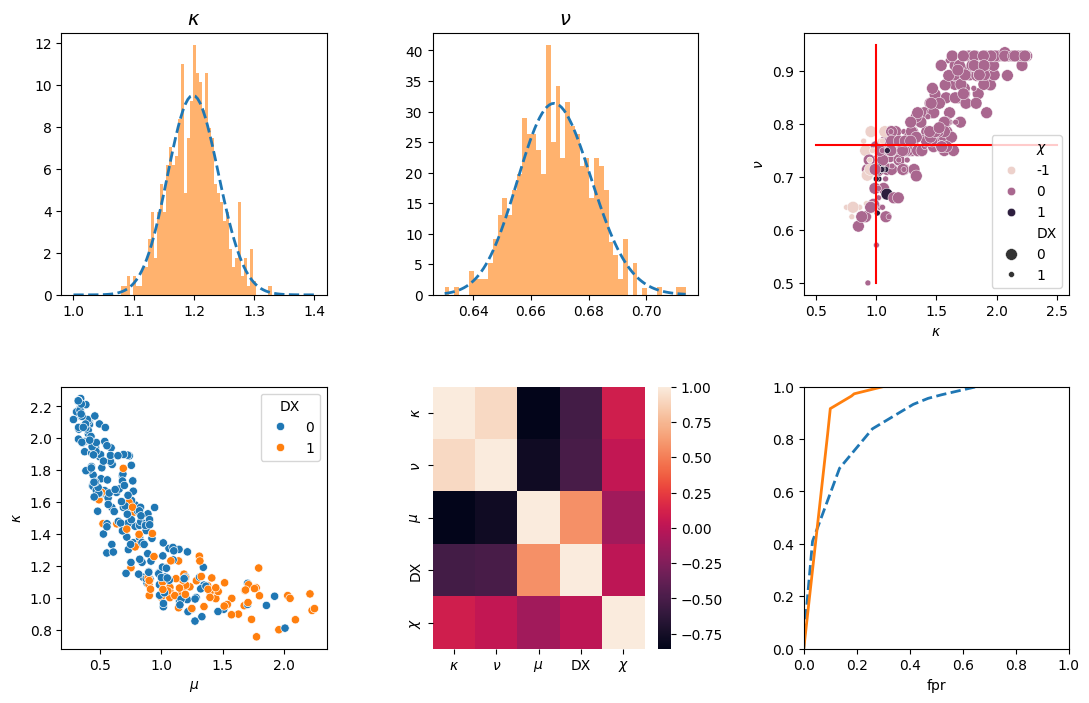

In [68]:
import numpy as np
import pylab as plt
import seaborn as sns
#from jupyterthemes import jtplot
#jtplot.style()


#plt.style.use('seaborn-talk')

plt.figure(figsize=[13,8])
plt.subplots_adjust(wspace=0.4, hspace=0.35)

# First subplot
plt.subplot(231)
x = np.linspace(xmin, xmax, 100)
plt.plot(x, ld.pdf(x), '--',lw=2)
plt.hist(lf, bins=50, density=True, alpha=0.6)
#plt.xlabel('X-axis label', fontsize=12)  # Set font size for x-label
#plt.ylabel('Y-axis label', fontsize=12)  # Set font size for y-label
plt.title('$\kappa$', fontsize=14)    # Set font size for title

# Adjust font size of tick labels
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Second subplot
plt.subplot(232)
xd = np.linspace(xmind, xmaxd, 100)
plt.plot(xd, vd.pdf(xd), '--',lw=2)
plt.hist(vf, bins=50, density=True, alpha=0.6)
plt.title(r"$\nu$", fontsize=14)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10);

# First subplot
plt.subplot(233)
C0=1
C1=0.76
C2=1.25
#ax=sns.scatterplot(data=response_dataframe,x='score',y='veritas',hue='dx')
#plt.plot([.2,2.5],[C1,C1],'-r')
#plt.plot([C2,C2],[.5,.95],'-r')
sns.scatterplot(data=wf2,x=r'$\kappa$',y=r'$\nu$',hue=r'$\chi$',size='DX')
plt.plot([.5,2.5],[.76,.76],'-r')
plt.plot([C0,C0],[.5,.95],'-r')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10);



# First subplot
plt.subplot(234)
sns.scatterplot(data=wf2,x=r'$\mu$',y=r'$\kappa$',hue='DX')
#plt.plot([.2,2.5],[C0,C0],'-r')
#plt.plot([C2,C2],[.5,2],'-r')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10);


# First subplot
plt.subplot(235)
sns.heatmap(wf2.corr())


# First subplot
plt.subplot(236)
zt.get().tpr.plot(lw=2,style='--')
ztmx.get().tpr.plot(lw=2)
plt.gca().set_xlim(0,1)
plt.gca().set_ylim(0,1)

# Adjust font size of tick labels
plt.xticks(fontsize=10)
plt.yticks(fontsize=10);

plt.savefig('fig2.pdf',dpi=600,bbox_inches='tight',transparent=True)


In [ ]:
plt.style.available